In [49]:
import re
import os
import numpy as np
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
regions = (
    gpd.read_file(
        Path.cwd().parent /
        'data' /
        'price_postprocessing' /
        'charge_restriction_regions.geojson')
    .set_index('LongName')["geometry"]
)

In [3]:
path = Path.cwd().parent / 'data' / 'price_postprocessing'

In [108]:
fn = path / 'Annex_3.xlsx'
file = pd.ExcelFile(fn)

print(file.sheet_names)


['Front sheet', 'Notes', '1. Outputs=>', '1a Network Cost Allowance-Elec', '2. Calculate=>', '2a TNUoS', '2b DUoS', '2c BSUoS', '3. Inputs=>', '3a Demand', '3b Losses', '3c TNUoS charges', '3d DUoS charges', '3e BSUoS charges', '3f DUoS charges (DCP268)', '3g BSUoS trans arrangment']


In [109]:
def clean_date(s):
    s = s.replace('–','-')
    return pd.Timestamp(s.replace(' ','').split('-')[0])

In [140]:
def get_sheet(name):

    df = pd.read_excel(
        fn,
        sheet_name=name,
        header=1,
        index_col=[1,2,3,5]
    )

    df.columns = df.iloc[5]
    df.index.names = ['metering', 'consumption', 'unit', 'region']
    df.columns.name = 'quarter'

    df = df.iloc[8:,4:]
    df = df.loc[:, ~df.columns.isna()]
    df.columns = df.columns.map(clean_date)

    return df

In [141]:
t = get_sheet('2a TNUoS')
d = get_sheet('2b DUoS')
b = get_sheet('2c BSUoS')

In [143]:
b

quarter                                                                                      2015-04-01  \
metering                            consumption   unit                    region                          
Single-Rate Metering Arrangement    m (3,100 kWh) £ per customer per year Eastern              6.414799   
                                                                          East Midlands        6.273128   
                                                                          London               6.337258   
                                                                          N Wales and Mersey   6.414595   
                                                                          Midlands             6.286319   
                                                                          Northern             6.337107   
                                                                          North West             6.3666   
                                                                          Southern             6.256886   
                                                                          South East           6.329067   
                                                                          South Wales          6.293468   
                                                                          Southern Western     6.189579   
                                                                          Yorkshire            6.418978   
                                                                          Southern Scotland    6.376162   
                                                                          Northern Scotland    6.378413   
Multi-Register Metering Arrangement m (4,200 kWh) £ per customer per year Eastern              8.675512   
                                                                          East Midlands        8.494893   
                                                                          London               8.568266   
                                                                          N Wales and Mersey   8.666649   
                                                                          Midlands              8.50749   
                                                                          Northern             8.568758   
                                                                          North West           8.615749   
                                                                          Southern             8.472508   
                                                                          South East           8.552348   
                                                                          South Wales          8.520074   
                                                                          Southern Western     8.385474   
                                                                          Yorkshire            8.676029   
                                                                          Southern Scotland    8.618762   
                                                                          Northern Scotland    8.644034   

quarter                                                                                      2015-10-01  \
metering                            consumption   unit                    region                          
Single-Rate Metering Arrangement    m (3,100 kWh) £ per customer per year Eastern              7.167482   
                                                                          East Midlands        7.009188   
                                                                          London               7.080843   
                                                                          N Wales and Mersey   7.167255   
                                                                          Midlands             7.023927   
                                        

C:\Users\lukas\AppData\Local\Temp\ipykernel_20572\254012630.py:37: PerformanceWarning: indexing past lexsort depth may impact performance.
  pdf = df.copy().loc[
C:\Users\lukas\AppData\Local\Temp\ipykernel_20572\254012630.py:54: PerformanceWarning: indexing past lexsort depth may impact performance.
  pdf = df.copy().loc[
C:\Users\lukas\AppData\Local\Temp\ipykernel_20572\254012630.py:37: PerformanceWarning: indexing past lexsort depth may impact performance.
  pdf = df.copy().loc[
C:\Users\lukas\AppData\Local\Temp\ipykernel_20572\254012630.py:54: PerformanceWarning: indexing past lexsort depth may impact performance.
  pdf = df.copy().loc[
C:\Users\lukas\AppData\Local\Temp\ipykernel_20572\254012630.py:37: PerformanceWarning: indexing past lexsort depth may impact performance.
  pdf = df.copy().loc[
C:\Users\lukas\AppData\Local\Temp\ipykernel_20572\254012630.py:42: PerformanceWarning: indexing past lexsort depth may impact performance.
  pdf = t.copy().loc[
C:\Users\lukas\AppData\Local\

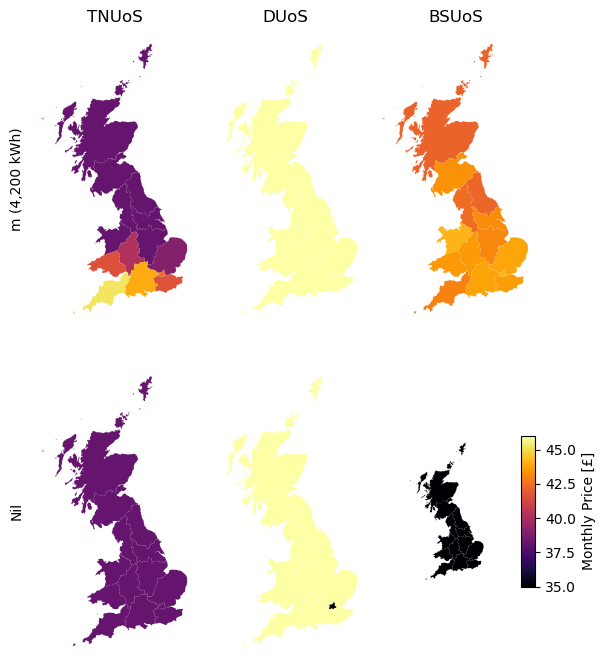

In [192]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

idx = pd.IndexSlice

fig, axs = plt.subplots(2, 3, figsize=(6, 7))

def process_network_allowance(pdf):
    pdf.index = pdf.index.get_level_values('region')
    pdf = pdf.rename(columns={pdf.columns[0]: 'price'})
    pdf = pd.concat([regions, pdf], axis=1)
    pdf['price'] = pdf['price'].astype(float)

    return gpd.GeoDataFrame(pdf)

total_min = np.inf
total_max = 0.

date = pd.Timestamp('2024-04')

vmin = 0
vmax = 200

vmin = 35
vmax = 46

nice_names = {
    "t": "TNUoS",
    "b": "BSUoS",
    "d": "DUoS",
}

for quant, ax in zip(['t', 'd', 'b'], axs.T):

    df = globals()[quant]

    try:
        pdf = df.copy().loc[
            idx["Multi-Register Metering Arrangement", "Nil"],
            [date]
            ]
    except KeyError:
        pdf = t.copy().loc[
            idx["Multi-Register Metering Arrangement", "Nil"],
            [date]
            ]
        pdf.values[:] = 0.

    pdf = process(pdf)
    pdf.plot(column='price', ax=ax[1], legend=False, vmin=vmin, vmax=vmax, cmap='inferno')

    total_min = min(total_min, pdf['price'].min())
    total_max = max(total_max, pdf['price'].max())

    pdf = df.copy().loc[
        idx["Multi-Register Metering Arrangement", "m (4,200 kWh)"],
        [date]
        ]
    pdf = process(pdf)

    pdf.plot(column='price', ax=ax[0], legend=False, cmap='inferno', vmin=vmin, vmax=vmax)

    total_min = min(total_min, pdf['price'].min())
    total_max = max(total_max, pdf['price'].max())

    ax[0].set_title(nice_names[quant])


                    
for ax, l in zip(axs, ['m (4,200 kWh)', 'Nil']):
    ax[0].set_ylabel(l)

for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

ax1_divider = make_axes_locatable(axs[1,2])

from matplotlib import colors
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm, cmap='inferno')

cax1 = ax1_divider.append_axes("right", size="10%", pad="2%")
cb1 = fig.colorbar(cbar, cax=cax1)

cax1.set_ylabel('Monthly Price [£]')#, rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

#### Policy

In [194]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

In [215]:
root = Path.cwd().parent / 'data' / 'price_postprocessing'

policy_path = path / 'Annex_4.xlsx'
file = pd.ExcelFile(fn)

file.sheet_names

['Front sheet',
 'Notes',
 '1. Outputs=>',
 '1a Policy Cost Allowance',
 '2. Calculate=>',
 '2a Aggregate costs',
 '3. Inputs=>',
 '3a Demand',
 '3b RO',
 '3d FIT',
 '3f WHD',
 '3e ECO',
 '3h Losses',
 '3g AAHEDC',
 '3i New FIT methodology',
 '3j GGL']

In [253]:
def get_ro(date):
    """Obtains Renewable Obligation (RO) from OFGEM price cap Annex 4. Unit: £/MWh."""

    series = pd.read_excel(
        policy_path,
        sheet_name='3e ECO',
        header=8,
    ).iloc[-1, 8:].dropna()
    series.name = 'RO cost estimate'

    series.index = series.index.map(clean_date)
    return series.loc[date].values[0]

get_ro('2024-04')

8.699329123

In [272]:
def get_fit(date):
    """Obtains New Methodology Feed-In Tariffs (FIT) from OFGEM price cap Annex 4. Unit: £/MWh supplied."""

    series = pd.read_excel(
        policy_path,
        sheet_name='3i New FIT methodology',
        header=219,
        index_col=1,
    ).iloc[-1, 2:]

    series = series.loc[~series.index.str.contains('Unnamed')].fillna(0.)
    series.index = series.index.map(clean_date)

    return series.loc[date].values[0]

get_fit('2024-04')

7.639091706

In [242]:
def get_old_fit(date):
    """Obtains (Outdated) Feed-In Tariffs (FIT) from OFGEM price cap Annex 4. Unit: £/MWh supplied."""

    series = pd.read_excel(
        policy_path,
        sheet_name='3d FIT',
        header=7,
        index_col=1,
    ).iloc[-1, 6:]

    series = series.loc[~series.index.str.contains('Unnamed')].fillna(0.)
    series.index = series.index.map(clean_date)
    
    try:
        return series.loc[date].values[0]
    except KeyError:
        return 0.

get_old_fit('2018-04')

5.312582056

In [252]:
def get_eco(date):
    """Obtains Energy Company Obligation (ECO) from OFGEM price cap Annex 4. Unit: £/MWh supplied."""

    series = pd.read_excel(
        policy_path,
        sheet_name='3e ECO',
        header=7,
        index_col=1,
    ).iloc[-1,6:].dropna()

    series.index = series.index.map(clean_date)

    return series.loc[date].values[0]

get_eco('2024-04')

8.699329123

In [259]:
def get_whd(date):
    """Obtains Warm Home Discount (WHD) from OFGEM price cap Annex 4. Unit: £/customer"""

    series = pd.read_excel(
        policy_path,
        sheet_name='3f WHD',
        header=7,
        index_col=1,
    ).iloc[-1,6:].dropna()

    series.index = series.index.map(clean_date)

    return series.loc[date].values[0]

get_whd('2024-04')

10.90926537

In [276]:
def get_aahedc(date):
    """Obtains Assistance for Areas with High Electricity Distribution
    Costs (AAHEDC) from OFGEM price cap Annex 4. Unit: £/MWh supplied"""

    series = pd.read_excel(
        policy_path,
        sheet_name='3g AAHEDC',
        header=7,
        index_col=1,
    ).iloc[-1,6:].dropna()

    series.index = series.index.map(clean_date)

    return series.loc[date].values[0]

get_aahedc('2024-04')

0.4551192438

In [330]:
def get_policy_summary(date, mode='multi'):
    """Obtains a summary of policy cost allowance from OFGEM price cap Annex 4. Unit: £/MWh supplied"""

    assert mode in ['multi', 'single']
    nice_modes = {
        'single': 'Electricity - Single-Rate Metering Arrangement',
        'multi': 'Electricity - Multi-Register Metering Arrangement',
    }

    df = pd.read_excel(
        policy_path,
        sheet_name='1a Policy Cost Allowance',
        header=11,
        index_col=[1,2],
    ).iloc[2:30, 4:]

    df = df.loc[idx[nice_modes[mode]], ~df.columns.str.contains('Unnamed')]
    df.columns = df.columns.map(clean_date)

    return df[pd.Timestamp(date)]


get_policy_summary('2023-01', mode='multi')

Eastern               166.498657
East Midlands         166.462312
London                166.496199
N Wales and Mersey    166.540568
Midlands              166.482459
Northern              166.465549
North West            166.483434
Southern              166.475573
South East            166.489602
South Wales           166.480424
Southern Western      166.450081
Yorkshire             166.511063
Southern Scotland      166.52394
Northern Scotland     166.517716
Name: 2023-01-01 00:00:00, dtype: object

#### MISC

In [147]:
import json
from pathlib import Path
import pandas as pd

In [149]:
data = json.load(open(Path.cwd().parent / 'results' / 'daily' / '2024-03.json'))

In [162]:

result = pd.DataFrame(
    index=pd.date_range('2024-03-01', '2024-03-31', freq='D'),
    columns=[
        'inverness nodal',
        'inverness zonal',
        'inverness national',
        'westminster nodal',
        'westminster zonal',
        'westminster national'
        ],
    )

for ts in result.index:

    tdata = data[str(int(ts.timestamp()))]

    result.loc[ts, 'inverness nodal'] = tdata['nodal']['geographies']['6440']['variables']['post_balancing_price']
    result.loc[ts, 'westminster nodal'] = tdata['nodal']['geographies']['5266']['variables']['post_balancing_price']

    result.loc[ts, 'inverness zonal'] = tdata['eso']['geographies']['GB0 Z1_4']['variables']['post_balancing_price']
    result.loc[ts, 'westminster zonal'] = tdata['eso']['geographies']['GB0 Z14']['variables']['post_balancing_price']

    result.loc[ts, 'inverness national'] = tdata['national']['geographies']['GB']['variables']['post_balancing_price']
    result.loc[ts, 'westminster national'] = tdata['national']['geographies']['GB']['variables']['post_balancing_price']


result

1709251200.0
{'nodal': {'geographies': {'4950': {'variables': {'wholesale_price': 71.0, 'post_balancing_price': 71.0, 'load': 103.5, 'available_capacity': 23.953125, 'dispatch': 23.953125}}, '4951': {'variables': {'wholesale_price': 71.0, 'post_balancing_price': 71.0, 'load': 93.75, 'available_capacity': 0.0, 'dispatch': 0.0}}, '4952': {'variables': {'wholesale_price': 71.0, 'post_balancing_price': 71.0, 'load': 93.0625, 'available_capacity': 0.0, 'dispatch': 0.0}}, '4953': {'variables': {'wholesale_price': 71.0, 'post_balancing_price': 71.0, 'load': 91.75, 'available_capacity': 0.0, 'dispatch': 0.0}}, '4955': {'variables': {'wholesale_price': 71.0, 'post_balancing_price': 71.0, 'load': 164.25, 'available_capacity': 0.0, 'dispatch': 0.0}}, '4956': {'variables': {'wholesale_price': 71.0, 'post_balancing_price': 71.0, 'load': 258.25, 'available_capacity': 1036.0, 'dispatch': 1036.0}}, '4958': {'variables': {'wholesale_price': 71.0, 'post_balancing_price': 71.0, 'load': 138.375, 'availabl

,inverness nodal,inverness zonal,inverness national,westminster nodal,westminster zonal,westminster national
2024-03-01,71.0,71.0,71.0,71.0,71.0,71.0
2024-03-02,50.75,52.59375,63.96875,63.375,63.5,63.96875
2024-03-03,49.15625,50.6875,63.96875,62.875,63.25,63.96875
2024-03-04,47.4375,48.15625,66.1875,64.9375,65.4375,66.1875
2024-03-05,1.923828,5.921875,76.25,69.5625,72.125,76.25
2024-03-06,20.0,21.4375,72.9375,71.0,72.625,72.9375
2024-03-07,58.375,58.65625,68.625,68.5,68.6875,68.625
2024-03-08,8.507812,16.578125,68.5,65.375,67.375,68.5
2024-03-09,2.046875,4.9375,63.40625,57.375,59.5,63.40625
2024-03-10,2.455078,6.449219,69.625,62.96875,65.25,69.625


In [165]:
result.to_csv('inverness_westminster_post_balancing_prices_march.csv')